# CS345 Final Project

### Project Imports

In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

### Load data

In [3]:
def load_news_dataset(dataset_name: str):
    base_path = os.getcwd() + '/data'
    dataset_path = Path(base_path) / dataset_name
    if not dataset_path.exists():
        raise FileNotFoundError(f"Dataset path not found: {dataset_path}")

    # load corpus.tsv
    corpus_path = dataset_path / "corpus.tsv"
    df = pd.read_csv(corpus_path, sep="\t")
    
    # load splits
    splits_path = dataset_path / "splits.json"
    splits = {}
    if splits_path.exists():
        with open(splits_path, "r") as f:
            splits = json.load(f)

    # load feature JSONs from features directory
    features_dir = dataset_path / "features"
    feature_data = {}
    if features_dir.exists():
        for json_file in features_dir.glob("*.json"):
            feature_name = json_file.stem
            with open(json_file, "r") as f:
                feature_data[feature_name] = json.load(f)
    
    return df, splits, feature_data

### ACL Dataset

In [4]:
acl_df, acl_splits, acl_features = load_news_dataset("acl2020")

acl_split_data = acl_splits.get('0', {})
acl_train_split_size = len(acl_split_data.get('train', []))
acl_test_split_size = len(acl_split_data.get('test', []))
acl_train_urls = acl_split_data.get('train', [])
acl_test_urls = acl_split_data.get('test', [])

print("ACL2020 Dataset:")
print(f"Articles: {len(acl_df)}")
print(f"Columns: {list(acl_df.columns)}")
print(f"Available features: {list(acl_features.keys())}")
print(f"Split sizes: train={acl_train_split_size} test={acl_test_split_size}")
print(acl_df.shape)

ACL2020 Dataset:
Articles: 859
Columns: ['source_url', 'source_url_normalized', 'ref', 'fact', 'bias']
Available features: ['youtube_subs', 'has_twitter', 'has_wikipedia', 'twitter_profile', 'youtube_numerical', 'youtube_fulltext', 'has_youtube', 'twitter_followers', 'has_facebook', 'articles_body_bert', 'youtube_nela', 'youtube_opensmile', 'articles_title_bert', 'wikipedia_content']
Split sizes: train=687 test=172
(859, 5)


### EMNLP Dataset

In [5]:
emnlp_df, emnlp_splits, emnlp_features = load_news_dataset("emnlp18")

emnlp_split_data = emnlp_splits.get('0', {})
emnlp_train_split_size = len(emnlp_split_data.get('train', []))
emnlp_test_split_size = len(emnlp_split_data.get('test', []))

print("EMNLP Dataset:")
print(f"Articles: {len(emnlp_df)}")
print(f"Columns: {list(emnlp_df.columns)}")
print(f"Available features: {list(emnlp_features.keys())}")
print(f"Split sizes: train={emnlp_train_split_size} test={emnlp_test_split_size}")
print(emnlp_df.shape)

EMNLP Dataset:
Articles: 1066
Columns: ['source_url', 'source_url_normalized', 'ref', 'fact', 'bias']
Available features: ['twitter_urlmatch', 'has_twitter', 'wikipedia_toc', 'has_wikipedia', 'twitter_description', 'twitter_created_at', 'twitter_haslocation', 'articles_body_glove', 'twitter_engagement', 'twitter_verified', 'url_structure', 'articles_title_glove', 'alexa', 'wikipedia_categories', 'wikipedia_summary', 'wikipedia_content']
Split sizes: train=851 test=215
(1066, 5)


### Baseline Metrics: ACL Bias Classification

In [6]:
# get BERT embeds
bert_features = acl_features['articles_body_bert']

# split by source_url
train_df = acl_df[acl_df['source_url_normalized'].isin(acl_train_urls)]
test_df = acl_df[acl_df['source_url_normalized'].isin(acl_test_urls)]

# use source_url_normalized as key
X_train = np.array([bert_features[url] for url in train_df['source_url_normalized']])
X_test = np.array([bert_features[url] for url in test_df['source_url_normalized']])
y_train = train_df['bias'].values
y_test = test_df['bias'].values

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (687, 768)
X_test shape: (172, 768)


In [7]:
# train logistic regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Baseline Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Baseline Accuracy: 0.5523

Classification Report:
              precision    recall  f1-score   support

      center       0.47      0.83      0.60        46
        left       0.50      0.02      0.04        55
       right       0.63      0.79      0.70        71

    accuracy                           0.55       172
   macro avg       0.53      0.54      0.44       172
weighted avg       0.55      0.55      0.46       172



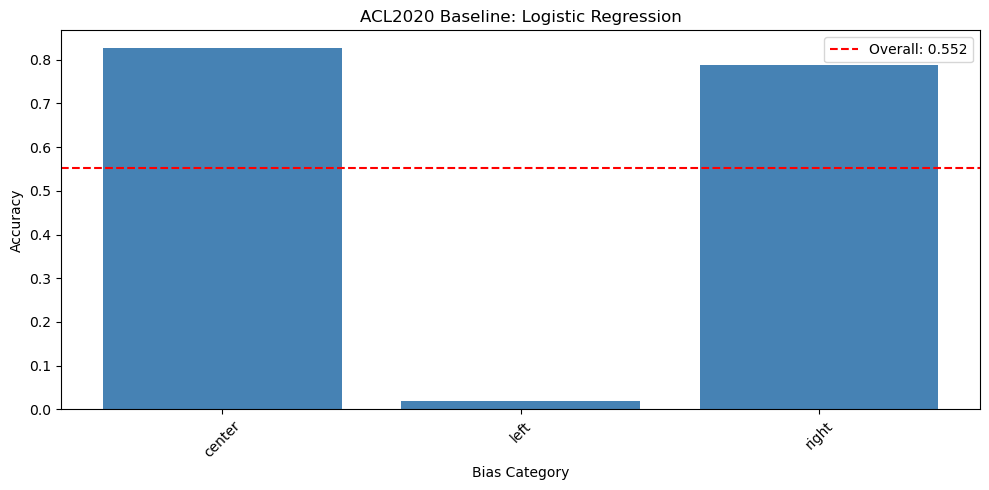

In [8]:
# plot accuracy by class
classes = np.unique(y_test)
class_acc = [accuracy_score(y_test[y_test == c], y_pred[y_test == c]) for c in classes]

plt.figure(figsize=(10, 5))
plt.bar(classes, class_acc, color='steelblue')
plt.axhline(y=accuracy, color='red', linestyle='--', label=f'Overall: {accuracy:.3f}')
plt.xlabel('Bias Category')
plt.ylabel('Accuracy')
plt.title('ACL2020 Baseline: Logistic Regression')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Train SVM with class balancing
svm_balanced = SVC(
    kernel='rbf', 
    random_state=42,
    class_weight='balanced',
    C=1.0,
    gamma='scale'
)

print("Training balanced SVM...")
svm_balanced.fit(X_train_scaled, y_train)

y_pred_balanced = svm_balanced.predict(X_test_scaled)
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)

print(f"\nBalanced SVM Accuracy: {accuracy_balanced:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_balanced, zero_division=0))

# Check predictions distribution
print(f"\nBalanced SVM predictions distribution:")
print(pd.Series(y_pred_balanced).value_counts().sort_index())

# Compare all models
print("\n" + "="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"Logistic Regression:  {accuracy:.4f}")
print(f"SVM (unbalanced):     {accuracy_svm:.4f}")
print(f"SVM (balanced):       {accuracy_balanced:.4f}")
print("="*50)

Training balanced SVM...

Balanced SVM Accuracy: 0.5756

Classification Report:
              precision    recall  f1-score   support

      center       0.71      0.43      0.54        46
        left       0.43      0.53      0.48        55
       right       0.65      0.70      0.68        71

    accuracy                           0.58       172
   macro avg       0.60      0.56      0.56       172
weighted avg       0.60      0.58      0.58       172


Balanced SVM predictions distribution:
center    28
left      67
right     77
Name: count, dtype: int64

MODEL COMPARISON
Logistic Regression:  0.5523


NameError: name 'accuracy_svm' is not defined